# Data Loading and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dython import nominal
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

In [2]:
data_dir = './data/'

In [3]:
results_dir = './data/results/'

In [4]:
models_dir = './models/'

In [5]:
model_name = 'decision_tree_regression'

In [6]:
regression_data = pd.read_csv(data_dir+'regression_data.csv', index_col=[0])

# Decision Tree (Regression)

Sort the dataset so we can drop the date column

In [7]:
regression_data = regression_data.sort_values(by=['date', 'team', 'department']).reset_index(drop=True)

In [8]:
dep_var = ['targeted_productivity']

In [9]:
regression_data

,date,department,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,...,targeted_productivity_rmean_1_1,targeted_productivity_rmean_2_1,targeted_productivity_rmean_1_2,targeted_productivity_rmean_2_2,actual_productivity_lag_2,actual_productivity_lag_4,actual_productivity_rmean_2_1,actual_productivity_rmean_4_1,actual_productivity_rmean_2_2,actual_productivity_rmean_4_2
0,2015-01-01,finishing,1,0.75,3.94,0.0,960,0,0.0,0,...,0.00,0.00,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2015-01-01,sweing,1,0.75,28.08,681.0,6900,45,0.0,0,...,0.75,0.00,0.375,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,2015-01-01,finishing,2,0.75,3.94,0.0,960,0,0.0,0,...,0.00,0.00,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,2015-01-01,sweing,2,0.75,19.88,733.0,6000,34,0.0,0,...,0.75,0.00,0.375,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,2015-01-01,sweing,3,0.75,28.08,795.0,6900,45,0.0,0,...,0.00,0.00,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2015-03-11,sweing,10,0.75,21.81,1674.0,6000,34,0.0,0,...,0.70,0.75,0.725,0.725,0.7505,0.7000,0.7505,0.7000,0.6140,0.5710
1193,2015-03-11,finishing,11,0.80,2.90,0.0,2400,0,0.0,0,...,0.80,0.80,0.800,0.800,0.8000,0.9604,0.8000,0.9604,0.8000,0.8580
1194,2015-03-11,sweing,11,0.80,11.41,560.0,3420,50,0.0,0,...,0.80,0.80,0.800,0.800,0.7583,0.8000,0.7583,0.8000,0.7793,0.8800
1195,2015-03-11,finishing,12,0.80,4.60,0.0,2160,0,0.0,0,...,0.80,0.80,0.800,0.800,0.9200,0.9030,0.9200,0.9030,0.8604,0.8516


In [10]:
categorical = np.array(['department', 'team'])

In [11]:
continuous = np.setdiff1d(np.setdiff1d(regression_data.columns,categorical), dep_var)

In [12]:
continuous = continuous[continuous != 'date']

In [13]:
X = regression_data.loc[:,np.union1d(categorical, continuous)]

In [14]:
y = regression_data.loc[:,dep_var]*100

In [15]:
columns = ['task', 'model', 'seed', 'split', 'criterions', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'valid_mean_value', 'predicted_mean_value', 'percentage_difference', 'valid_rsq', 'valid_mae', 'valid_mse', 'valid_rmse']
decision_tree_regression_results_df = pd.DataFrame(columns=columns)
df_rows = 0

Now we need to prepare our data and the cross-validation process so that we can start training. As we are dealing with time-series we need to split the data appropriately. We will use 20% of the data for testing.

In [16]:
# Random 6-digit seed
test_seed = 513370

In [17]:
test_idx = int((0.2*len(X)))

In [18]:
X_train, X_test, y_train, y_test = X.iloc[:len(X)- test_idx, :], X.iloc[len(X)- test_idx:, :], y.iloc[:len(y)- test_idx, :], y.iloc[len(y)- test_idx:, :]

In [19]:
# 5 random 6 digit numbers
seeds = [660108, 720389, 193768, 586930, 327407]

In [29]:
pd.options.mode.chained_assignment = None  # default='warn'
# Cross-Validation Pipeline
for seed in seeds:
    print(f'Starting training for seed {seed}')
    # assign the tuned parameters
    split = 0
    criterions = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
    max_depths = [depth for depth in range(5, 65, 5)]
    min_samples_splits = [2, 3, 4]
    min_samples_leaves = [8, 10, 12]
    max_features_n = ['auto', 'sqrt', 'log2']
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, valid_index in tscv.split(X_train):
        # Data Split
        split += 1
        X_train_curr_split = X_train.iloc[train_index]
        X_valid_curr_split = X_train.iloc[valid_index]
        y_train_curr_split = y_train.iloc[train_index]
        y_valid_curr_split = y_train.iloc[valid_index]
        # Avoiding data leakage for input values
        # We need to encode only categorical variables
        enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)
        X_train_curr_split.loc[:, categorical] = enc.fit_transform(X_train_curr_split[categorical])
        X_valid_curr_split.loc[:, categorical] = enc.transform(X_valid_curr_split[categorical])

        y_train_curr_split = y_train_curr_split.values.flatten()
        y_valid_curr_split = y_valid_curr_split.values.flatten()
        for criterion in criterions:
            for max_depth in max_depths:
                for min_samples_split in min_samples_splits:
                    for min_samples_leaf in min_samples_leaves:
                        for max_features in max_features_n:
                            model =  DecisionTreeRegressor(criterion=criterion,
                                                           max_depth=max_depth,
                                                           min_samples_split=min_samples_split,
                                                           min_samples_leaf=min_samples_leaf,
                                                           max_features=max_features,
                                                           random_state=seed
                                                           )
                            pipe = make_pipeline(preprocessing.StandardScaler(), 
                                                 model
                                                )
                            # train the model
                            pipe.fit(X_train_curr_split, y_train_curr_split)
                            valid_predictions = pipe.predict(X_valid_curr_split)
                            # Obtain metric scores
                            valid_mae = mean_absolute_error(y_valid_curr_split, valid_predictions)
                            valid_mse = mean_squared_error(y_valid_curr_split, valid_predictions)
                            valid_rmse = mean_squared_error(y_valid_curr_split, valid_predictions, squared=False)
                            valid_rsq = r2_score(y_valid_curr_split, valid_predictions)
                            valid_mean_value = y_valid_curr_split.mean()
                            predicted_mean_value = valid_predictions.mean()
                            percetange_difference = ((y_valid_curr_split - valid_predictions)/(y_valid_curr_split)).mean()
                            decision_tree_regression_results_df.loc[df_rows] = ['regression',
                                                                                'decision tree',
                                                                                seed,
                                                                                split,
                                                                                criterion,
                                                                                max_depth,
                                                                                min_samples_split,
                                                                                min_samples_leaf,
                                                                                max_features,
                                                                                valid_mean_value,
                                                                                predicted_mean_value,
                                                                                percetange_difference,
                                                                                valid_rsq,
                                                                                valid_mae,
                                                                                valid_mse,
                                                                                valid_rmse
                                                                                ]
                            # increment the rows variable
                            df_rows +=1
    print(f'Done training for seed {seed}')     


Starting training for seed 660108
Done training for seed 660108
Starting training for seed 720389
Done training for seed 720389
Starting training for seed 193768
Done training for seed 193768
Starting training for seed 586930
Done training for seed 586930
Starting training for seed 327407
Done training for seed 327407


## Functions

In [20]:
def group_seeded_data(data, groupby_columns, droped_cols=['seed', 'split']):
    grouped_data = data.groupby(groupby_columns).agg('mean').reset_index().drop(droped_cols, axis=1)
    return grouped_data

In [23]:
decision_tree_regression_results_df

,task,model,seed,split,criterions,max_depth,min_samples_split,min_samples_leaf,max_features,valid_mean_value,predicted_mean_value,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
0,regression,decision tree,660108,1,squared_error,5,2,8,auto,73.364780,75.809391,-0.067915,0.177121,5.427586,114.503569,10.700634
1,regression,decision tree,660108,1,squared_error,5,2,8,sqrt,73.364780,76.251660,-0.075896,0.002181,5.567900,138.846530,11.783316
2,regression,decision tree,660108,1,squared_error,5,2,8,log2,73.364780,76.736135,-0.082764,0.112197,5.112985,123.537815,11.114757
3,regression,decision tree,660108,1,squared_error,5,2,10,auto,73.364780,75.703504,-0.066987,0.196400,5.545890,111.820852,10.574538
4,regression,decision tree,660108,1,squared_error,5,2,10,sqrt,73.364780,77.239425,-0.091130,0.065346,5.230949,130.057025,11.404255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32395,regression,decision tree,327407,5,poisson,60,4,10,sqrt,73.144654,71.061440,0.016398,-0.234272,6.934690,83.275864,9.125561
32396,regression,decision tree,327407,5,poisson,60,4,10,log2,73.144654,70.727857,0.023542,0.086564,5.378037,61.629173,7.850425
32397,regression,decision tree,327407,5,poisson,60,4,12,auto,73.144654,69.589579,0.035180,-0.287875,7.032875,86.892445,9.321612
32398,regression,decision tree,327407,5,poisson,60,4,12,sqrt,73.144654,68.556964,0.050469,-0.452254,7.751964,97.983087,9.898641


In [24]:
decision_tree_regression_results_df.to_csv(results_dir + 'decision_tree_regression_results_df.csv')

Aggregate the values so that we average the results for each split

In [26]:
grouped_decision_tree_regression_results_df = group_seeded_data(decision_tree_regression_results_df, 
                                                                 ['criterions', 'max_depth','min_samples_split', 'min_samples_leaf', 'max_features'],
                                                                 )

In [27]:
grouped_decision_tree_regression_results_df

,criterions,max_depth,min_samples_split,min_samples_leaf,max_features,valid_mean_value,predicted_mean_value,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
0,absolute_error,5,2,8,auto,72.41761,73.713208,-0.048863,0.191702,3.916981,85.803774,9.163586
1,absolute_error,5,2,8,log2,72.41761,74.027044,-0.055047,0.105576,4.464780,92.860692,9.559643
2,absolute_error,5,2,8,sqrt,72.41761,73.981761,-0.054388,0.137131,4.220755,90.795912,9.420829
3,absolute_error,5,2,10,auto,72.41761,73.995597,-0.052514,0.244565,3.781761,79.896541,8.815140
4,absolute_error,5,2,10,log2,72.41761,74.247170,-0.058102,0.131428,4.262264,91.385220,9.443478
...,...,...,...,...,...,...,...,...,...,...,...,...
1291,squared_error,60,4,10,log2,72.41761,72.691228,-0.034159,0.196089,4.950189,83.144611,9.061181
1292,squared_error,60,4,10,sqrt,72.41761,72.418099,-0.030062,0.156806,5.281237,87.165776,9.274272
1293,squared_error,60,4,12,auto,72.41761,72.265554,-0.026288,0.272268,4.760421,74.911416,8.589236
1294,squared_error,60,4,12,log2,72.41761,72.544638,-0.032279,0.177510,5.147131,84.782095,9.150116


In [33]:
grouped_decision_tree_regression_results_df.to_csv(results_dir + 'grouped_decision_tree_regression_results_df.csv')

## Functions

In [34]:
def plot_line(data, x_column = 'max_depth', groupby_column = 'criterions', title='Line graph', title_size=25, axes_size=15, tick_size=12, acc = 'valid_mae'):
    grouped_data = data.groupby([groupby_column, x_column]).agg(acc=(acc, 'mean')).reset_index()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    for feat in grouped_data[groupby_column].unique():
        feat_data = grouped_data[grouped_data[groupby_column]==feat].copy()
        X = feat_data[x_column]
        y = feat_data['acc'].copy()
        plt.plot(X, y, label=f'{groupby_column}_{feat}')
    
    acc_label = acc
    fig.legend(bbox_to_anchor=(0.9, 0.9))
    fig.suptitle(title + f' for {acc} change in regards to {x_column} for each value of {groupby_column}', fontsize=title_size,  y=1.02)
    ax.set_xlabel('C', fontsize=axes_size)
    ax.set_ylabel(f'{acc_label}'.capitalize(), fontsize=axes_size)
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

In [155]:
def plot_difference(y_test, predictions_test, title='Scatter plot', title_size=25, axes_size=15, tick_size=12, acc = 'valid_accuracy'):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.scatter(y_test, predictions_test)
    min_y = y_test.min()
    min_predictions = predictions_test.min()
    min_val = np.minimum(min_y, min_predictions)
    ax.axline((min_val, min_val), slope=1, color='black')   
    
    acc_label = acc.split('_')
    fig.suptitle(title + f' for expected vs predicted output', fontsize=title_size,  y=1.02)
    ax.set_xlabel('Expected output', fontsize=axes_size)
    ax.set_ylabel('Predicted output', fontsize=axes_size)
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

## Overal results demonstration

### MAE

#### Min_samples_leaf

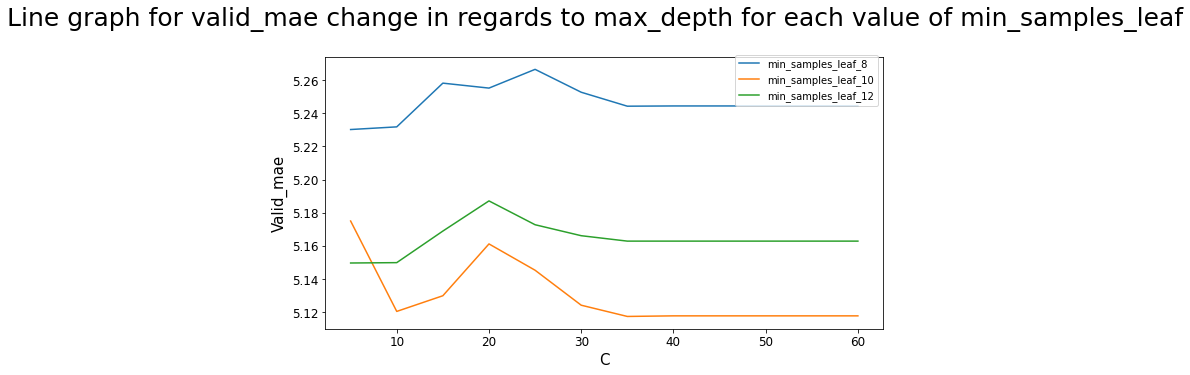

In [30]:
plot_line(grouped_decision_tree_regression_results_df, groupby_column='min_samples_leaf')

#### Min_samples_split

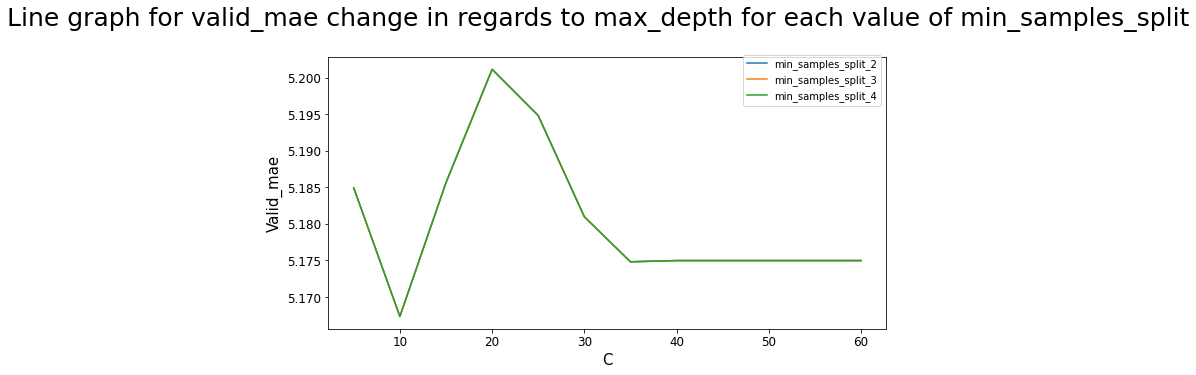

In [31]:
plot_line(grouped_decision_tree_regression_results_df, groupby_column='min_samples_split')

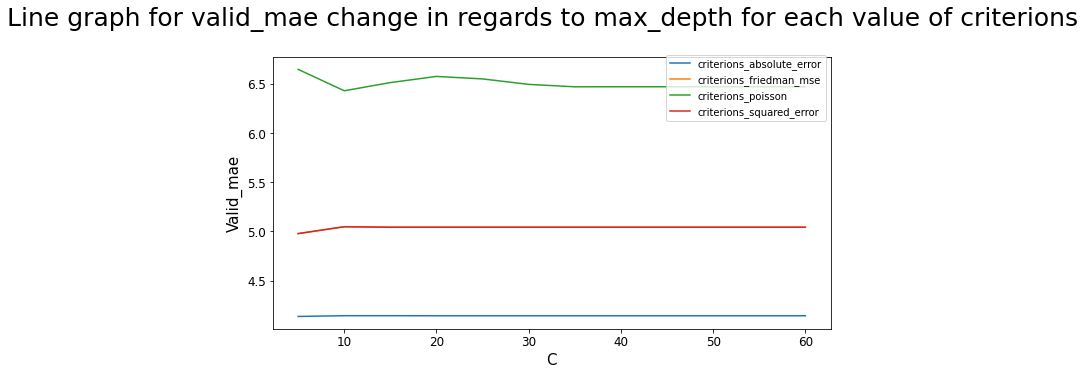

In [35]:
plot_line(grouped_decision_tree_regression_results_df)

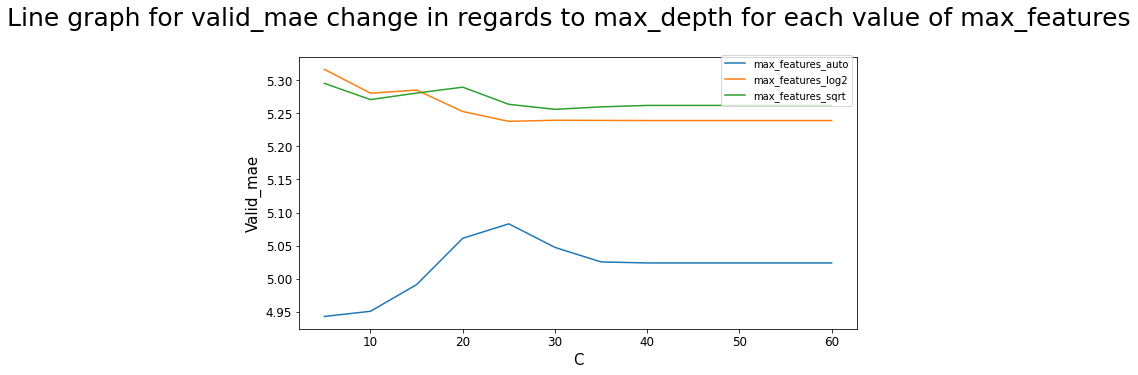

In [36]:
plot_line(grouped_decision_tree_regression_results_df, groupby_column='max_features')

From the above graphs it can be observed that `min_samples_leaf` works the best with the value of 10 in regards to the evaluation metric. However, the cahnge in the value of `min_samples_split` seems to have no impact on the model's performance. The best criterion seems to be absolute error one, however, increasing the depth of the tree does not seem to impact the evaluation metric. The `auto` value of the max_features parameter seems to work the best on the current data.

### MSE

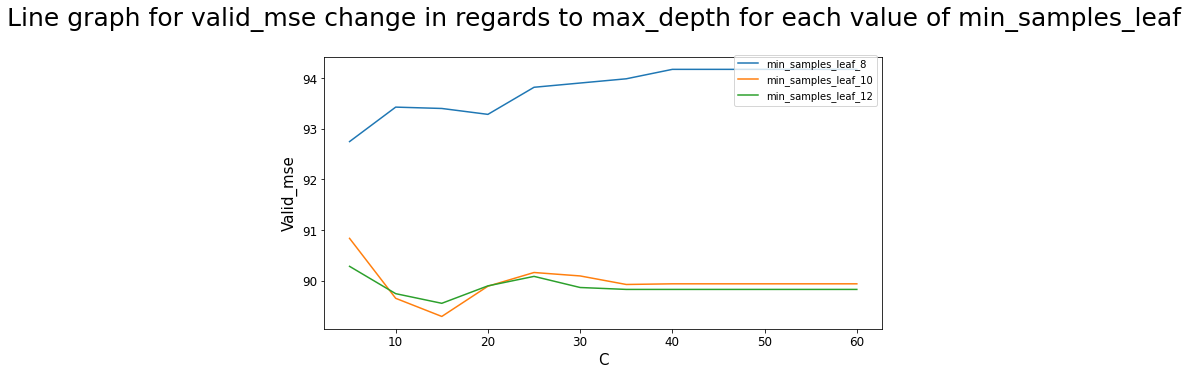

In [37]:
plot_line(grouped_decision_tree_regression_results_df, groupby_column='min_samples_leaf', acc='valid_mse')

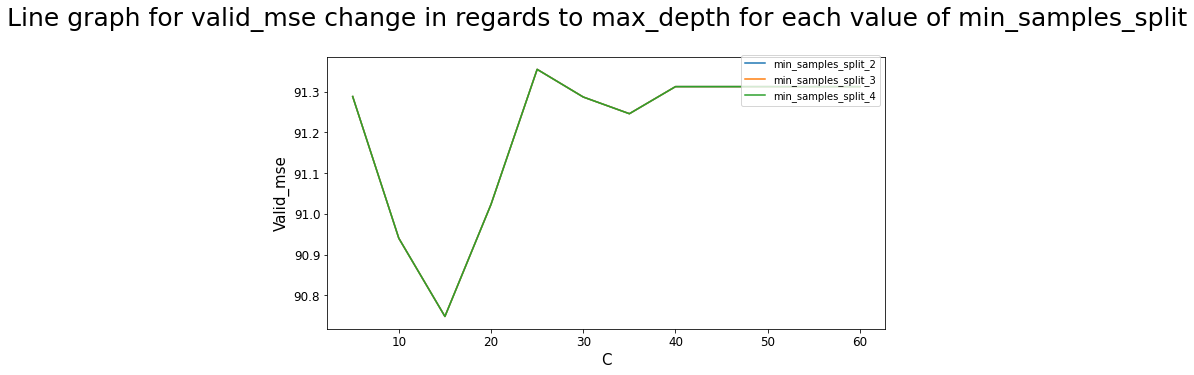

In [38]:
plot_line(grouped_decision_tree_regression_results_df, groupby_column='min_samples_split', acc='valid_mse')

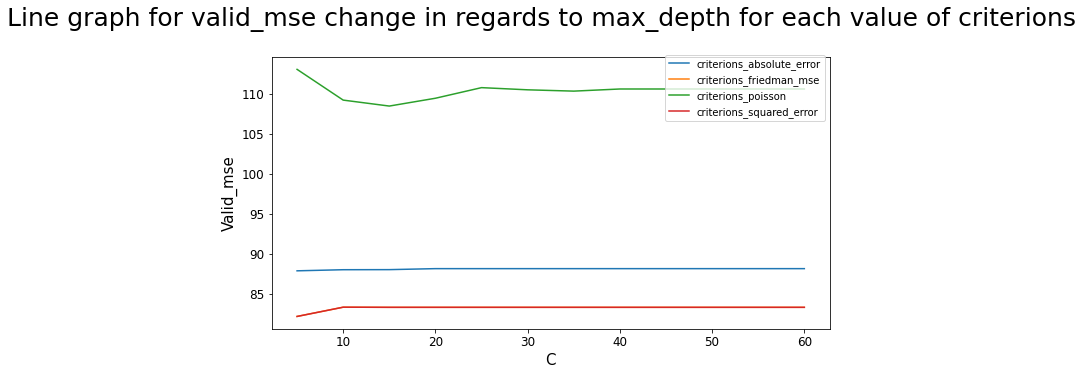

In [39]:
plot_line(grouped_decision_tree_regression_results_df, acc='valid_mse')

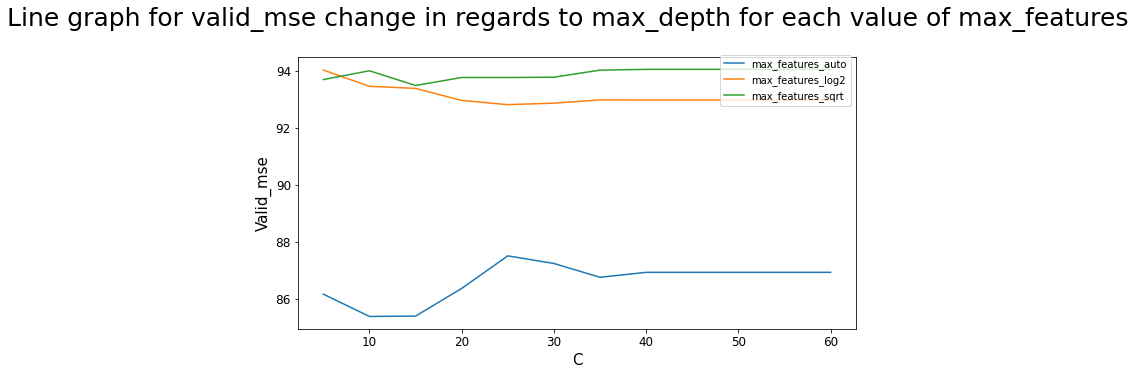

In [40]:
plot_line(grouped_decision_tree_regression_results_df, groupby_column='max_features', acc='valid_mse')

When recording MSE, the overal picture is almost the same. The only difference is the `criterion` parameter value, which is the best when its value is squared error. However, absolute_error is prettty close to it.

## Build best model

In [71]:
grouped_decision_tree_regression_results_df[grouped_decision_tree_regression_results_df['valid_rmse'] == grouped_decision_tree_regression_results_df['valid_rmse'].min()]

,criterions,max_depth,min_samples_split,min_samples_leaf,max_features,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
60,absolute_error,15,2,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
69,absolute_error,15,3,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
78,absolute_error,15,4,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
87,absolute_error,20,2,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
96,absolute_error,20,3,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
105,absolute_error,20,4,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
114,absolute_error,25,2,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
123,absolute_error,25,3,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
132,absolute_error,25,4,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
141,absolute_error,30,2,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356


In [72]:
grouped_decision_tree_regression_results_df[grouped_decision_tree_regression_results_df['valid_mse'] == grouped_decision_tree_regression_results_df['valid_mse'].min()]

,criterions,max_depth,min_samples_split,min_samples_leaf,max_features,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
60,absolute_error,15,2,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
69,absolute_error,15,3,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
78,absolute_error,15,4,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
87,absolute_error,20,2,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
96,absolute_error,20,3,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
105,absolute_error,20,4,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
114,absolute_error,25,2,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
123,absolute_error,25,3,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
132,absolute_error,25,4,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356
141,absolute_error,30,2,12,auto,-0.050832,0.303568,3.701258,73.421698,8.461356


In [73]:
grouped_decision_tree_regression_results_df[grouped_decision_tree_regression_results_df['valid_mae'] == grouped_decision_tree_regression_results_df['valid_mae'].min()]

,criterions,max_depth,min_samples_split,min_samples_leaf,max_features,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
33,absolute_error,10,2,12,auto,-0.050796,0.303741,3.688679,73.547484,8.468586
42,absolute_error,10,3,12,auto,-0.050796,0.303741,3.688679,73.547484,8.468586
51,absolute_error,10,4,12,auto,-0.050796,0.303741,3.688679,73.547484,8.468586


In [74]:
grouped_decision_tree_regression_results_df[grouped_decision_tree_regression_results_df['valid_rsq'] == grouped_decision_tree_regression_results_df['valid_rsq'].max()]

,criterions,max_depth,min_samples_split,min_samples_leaf,max_features,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
33,absolute_error,10,2,12,auto,-0.050796,0.303741,3.688679,73.547484,8.468586
42,absolute_error,10,3,12,auto,-0.050796,0.303741,3.688679,73.547484,8.468586
51,absolute_error,10,4,12,auto,-0.050796,0.303741,3.688679,73.547484,8.468586


Now we need to save the best model and test it on the test data. Given that we have different parameters for max_depth, we may have to aggregate

In [147]:
model =  DecisionTreeRegressor(criterion='absolute_error',
                               max_depth=12,
                               min_samples_split=2,
                               min_samples_leaf=12,
                               max_features='auto',
                               random_state=test_seed)
best_pipe = make_pipeline(preprocessing.StandardScaler(), 
                          model
                         )

In [148]:
enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)
X_train.loc[:, categorical] = enc.fit_transform(X_train[categorical])
X_test.loc[:, categorical] = enc.transform(X_test[categorical])

y_train_enc = y_train.values.flatten()
y_test_enc = y_test.values.flatten()

In [149]:
best_pipe.fit(X_train, y_train_enc)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=12,
                                       max_features='auto', min_samples_leaf=12,
                                       random_state=513370))])

Obtain metric scores

In [150]:
test_predictions = best_pipe.predict(X_test)
test_mae = mean_absolute_error(y_test_enc, test_predictions)
test_mse = mean_squared_error(y_test_enc, test_predictions)
test_rmse = mean_squared_error(y_test_enc, test_predictions, squared=False)
test_rsq = r2_score(y_test_enc, test_predictions)

### Results on test set

In [151]:
print(f"The MAE score on the test set for the best model is {test_mae.round(3)} \n")

The MAE score on the test set for the best model is 2.364 



In [152]:
print(f"The MSE score on the test set for the best model is {test_mse.round(3)} \n")

The MSE score on the test set for the best model is 43.41 



In [153]:
print(f"The RMSE score on the test set for the best model is {test_rmse.round(3)} \n")

The RMSE score on the test set for the best model is 6.589 



In [154]:
print(f"The Rsq score on the test set for the best model is {test_rsq.round(3)} \n")

The Rsq score on the test set for the best model is 0.456 



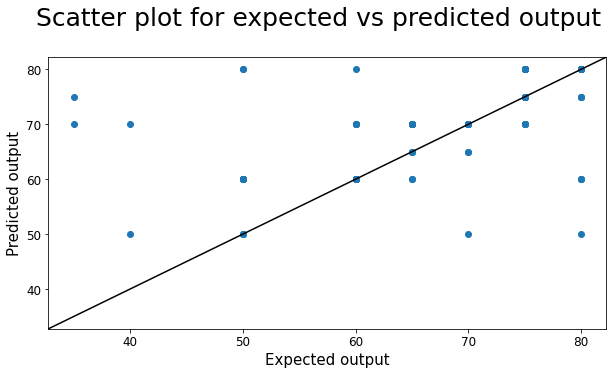

In [156]:
plot_difference(y_test_enc, test_predictions)

Save the model on disc

In [160]:
pickle.dump(best_pipe, open(models_dir+model_name, 'wb'))

Load the model from disk

In [161]:
loaded_best_pipe = pickle.load(open(models_dir+model_name, 'rb'))